# Prediction of Churn

__In the EDA section, we explored the variables and got a sense of the variables that have some impact on the churn of the customer.__

## Data Dictionary

There are multiple variables in the dataset which can be cleanly divided in 3 categories:

### Demographic information about customers

<b>customer_id</b> - Customer id

<b>vintage</b> - Vintage of the customer with the bank in number of days

<b>age</b> - Age of customer

<b>gender</b> - Gender of customer

<b>dependents</b> - Number of dependents

<b>occupation</b> - Occupation of the customer 

<b>city</b> - City of customer (anonymised)


### Customer Bank Relationship


<b>customer_nw_category</b> - Net worth of customer (3:Low 2:Medium 1:High)

<b>branch_code</b> - Branch Code for customer account

<b>days_since_last_transaction</b> - No of Days Since Last Credit in Last 1 year


### Transactional Information

<b>current_balance</b> - Balance as of today

<b>previous_month_end_balance</b> - End of Month Balance of previous month


<b>average_monthly_balance_prevQ</b> - Average monthly balances (AMB) in Previous Quarter

<b>average_monthly_balance_prevQ2</b> - Average monthly balances (AMB) in previous to previous quarter

<b>current_month_credit</b> - Total Credit Amount current month

<b>previous_month_credit</b> - Total Credit Amount previous month

<b>current_month_debit</b> - Total Debit Amount current month

<b>previous_month_debit</b> - Total Debit Amount previous month

<b>current_month_balance</b> - Average Balance of current month

<b>previous_month_balance</b> - Average Balance of previous month

<b>churn</b> - Average balance of customer falls below minimum balance in the next quarter (1/0)


## Churn Prediction using Logisitic Regression

Now, that we understand the dataset in detail. It is time to build a logistic regression model to predict the churn. I have included the data dictionary again here for reference.

* Load Data & Packages for model building & preprocessing
* Preprocessing & Missing value imputation
* Select features on the basis of EDA Conclusions & build baseline model
* Decide Evaluation Metric on the basis of business problem
* Build model using all features & compare with baseline
* Use Reverse Feature Elimination to find the top features and build model using the top 10 features & compare

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [10]:
df = pd.read_csv('churn_prediction.csv')

### Missing Values
Before we go on to build the model, we must look for missing values within the dataset as treating the missing values  is a necessary step before we fit a logistic regression model on the dataset.

In [11]:
pd.isnull(df).sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

### Gender

In [12]:
df['gender'].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

There is a good mix of both males and females so values cannot be filled with any one of them. We could create a separate category by assigning the value -1 for all missing values in this column.

But before that, we will first convert gender into 0/1 and then replace values missing values with -1

In [13]:
dict_gender = {'Male': 1, 'Female':0}
df.replace({'gender': dict_gender}, inplace = True)

df['gender'] = df['gender'].fillna(-1)

#### Dependents, occupation and city with mode

Next we will have a quick look at the dependents & occupations column and impute with mode.

In [14]:
df['dependents'].value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
9.0         1
52.0        1
36.0        1
50.0        1
8.0         1
25.0        1
32.0        1
Name: dependents, dtype: int64

In [15]:
df['occupation'].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [16]:
df['city'].value_counts()

1020.0    3479
1096.0    2016
409.0     1334
146.0     1291
834.0     1138
          ... 
748.0        1
1099.0       1
108.0        1
655.0        1
723.0        1
Name: city, Length: 1604, dtype: int64

In [17]:
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')
df['city'] = df['city'].fillna(1020)


In [18]:
df['days_since_last_transaction'] = df['days_since_last_transaction'].fillna(999)

### Preprocessing

Now, before applying linear model such as logistic regression, we need to scale the data and keep all features as numeric strictly. 


In [19]:
# Convert occupation to one hot encoded features
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

### Scaling Numerical Features for Logistic Regression

Now, we remember that there are a lot of outliers in the dataset especially when it comes to previous and current balance features. Also, the distributions are skewed for these features if you recall from the EDA. We will take 2 steps to deal with that here:
* Log Transformation
* Standard Scaler

Standard scaling is anyways a necessity when it comes to linear models and we have done that here after doing log transformation on all balance features.

In [20]:
num_cols = ['current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']
for i in num_cols:
    df[i] = np.log(df[i] + 17000)

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)


In [21]:
df= df.drop(columns= num_cols, axis=1)
df= df.merge(scaled, left_index= True, right_index= True, how= 'left')

In [22]:
y= df.churn
df= df.drop(['churn','customer_id', 'occupation'], axis=1)

## Model Building and Evaluation Metrics
Since this is a binary classification problem, we could use the following 2 popular metrics:

1. Recall
2. Area under the Receiver operating characteristic curve

__Now, we are looking at the recall value here because a customer falsely marked as churn would not be as bad as a customer who was not detected as a churning customer and appropriate measures were not taken by the bank to stop him/her from churning__

The ROC AUC is the area under the curve when plotting the (normalized) true positive rate (x-axis) and the false positive rate (y-axis).

Our main metric here would be Recall values, while AUC ROC Score would take care of how well predicted probabilites are able to differentiate between the 2 classes.

### Conclusions from EDA
* For debit values, we see that there is a significant difference in the distribution for churn and non churn and it might be turn out to be an important feature
* For all the balance features the lower values have much higher proportion of churning customers
* For most frequent vintage values, the churning customers are slightly higher, while for higher values of vintage, we have mostly non churning customers which is in sync with the age variable 
* We see significant difference for different occupations and certainly would be interesting to use as a feature for prediction of churn.

Now, we will first split our dataset into test and train and using the above conclusions select columns and build a baseline logistic regression model to check the ROC-AUC Score & the confusion matrix

In [23]:
baseline_cols = ['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']

In [24]:
df_baseline= df[baseline_cols]

### Train test split

In [25]:
# Splitting the data into Train and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df_baseline,y,test_size=1/3, random_state=11, stratify = y)

model = LogisticRegression()
model.fit(xtrain,ytrain)
pred = model.predict_proba(xtest)[:,1]

### AUC ROC Curve & Confusion Matrix 

Now, let us quickly look at the AUC-ROC curve for our logistic regression model and also the confusion matrix to see where the logistic regression model is failing here.

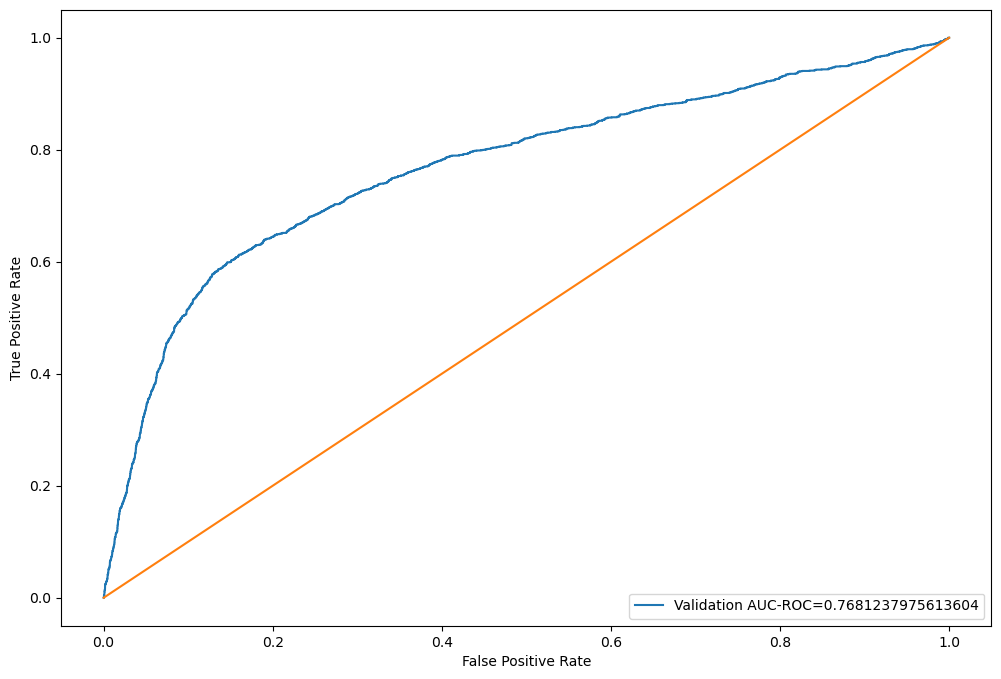

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,pred) 
auc = roc_auc_score(ytest, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [27]:
# Confusion Matrix
pred_val = model.predict(xtest)

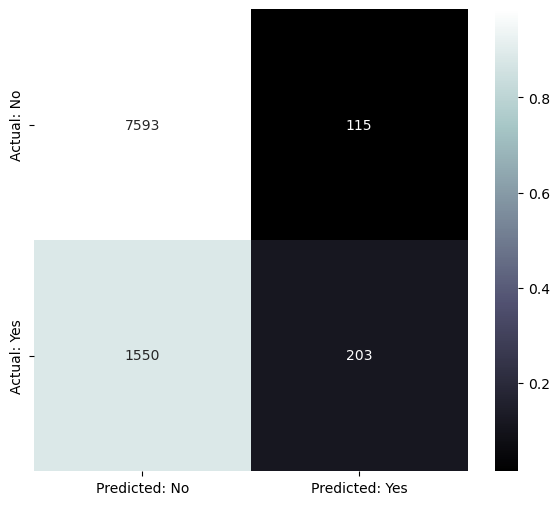

In [28]:
label_preds = pred_val

cm = confusion_matrix(ytest,label_preds)


def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'], cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [29]:
# Recall Score
recall_score(ytest,pred_val)

0.11580148317170565

### Cross Validation

We divide the entire population into k equal samples. Now we train models on k-1 samples and validate on 1 sample. Then, at the second iteration we train the model with a different sample held as validation. 

In k iterations, we have basically built model on each sample and held each of them as validation. This is a way to reduce the selection bias and reduce the variance in prediction power.

In [30]:
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        x_train,x_val = df1.loc[df_index],df1.loc[test_index]
        y_train,y_val = y.loc[df_index],y.loc[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(x_train, y_train)
        pred_probs = model.predict_proba(x_val)
        pp = []
         
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        roc_score = roc_auc_score(y_val,pred_probs[:,1])
        recall = recall_score(y_val,pred_val)
        precision = precision_score(y_val,pred_val)
        sufix = ""
        msg = ""
        msg += "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f} ".format(roc_score, recall,precision)
        print("{}".format(msg))
         
         # Save scores
        cv_scores.append(roc_score)
        i+=1
    return cv_scores

In [31]:
baseline_scores = cv_score(LogisticRegression(), cols = baseline_cols)


1 of kfold 5
ROC AUC Score: 0.7644836090843695, Recall Score: 0.0751, Precision Score: 0.5766 

2 of kfold 5
ROC AUC Score: 0.7791873394306855, Recall Score: 0.0770, Precision Score: 0.6532 

3 of kfold 5
ROC AUC Score: 0.7552813803333904, Recall Score: 0.1359, Precision Score: 0.6441 

4 of kfold 5
ROC AUC Score: 0.7582070977015274, Recall Score: 0.1169, Precision Score: 0.6508 

5 of kfold 5
ROC AUC Score: 0.7622546278632232, Recall Score: 0.1112, Precision Score: 0.5821 


In [32]:
print(np.mean(baseline_scores))

0.7638828108826392


In [33]:
all_feat_scores = cv_score(LogisticRegression())


1 of kfold 5
ROC AUC Score: 0.7734888500667969, Recall Score: 0.1702, Precision Score: 0.6654 

2 of kfold 5
ROC AUC Score: 0.771658411262974, Recall Score: 0.1530, Precision Score: 0.6880 

3 of kfold 5
ROC AUC Score: 0.7448586149959873, Recall Score: 0.0789, Precision Score: 0.6484 

4 of kfold 5
ROC AUC Score: 0.749227867170129, Recall Score: 0.1036, Precision Score: 0.6450 

5 of kfold 5
ROC AUC Score: 0.7480970091570514, Recall Score: 0.1226, Precision Score: 0.5811 


In [34]:
print(np.mean(all_feat_scores))

0.7574661505305876


### Reverse Feature Elimination or Backward Selection

We have already built a model using all the features and a separate model using some baseline features. We can try using backward feature elimination to check if we can do better. Let's do that next.

In [35]:
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Create the RFE object and rank each feature
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe.fit(df, y)

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [36]:
ranking_df = pd.DataFrame()
ranking_df['Feature_name'] = df.columns
ranking_df['Rank'] = rfe.ranking_
ranked = ranking_df.sort_values(by=['Rank'])
ranked 

,Feature_name,Rank
13,current_balance,1
16,average_monthly_balance_prevQ,2
8,occupation_company,3
15,average_monthly_balance_prevQ2,4
21,current_month_balance,5
22,previous_month_balance,6
19,current_month_debit,7
11,occupation_self_employed,8
10,occupation_salaried,9
12,occupation_student,10


Balance features are coming up at the top

In [37]:
rfe_top_10_scores = cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values)


1 of kfold 5
ROC AUC Score: 0.7986881101633954, Recall Score: 0.2281, Precision Score: 0.7362 

2 of kfold 5
ROC AUC Score: 0.8050442914397288, Recall Score: 0.2234, Precision Score: 0.7556 

3 of kfold 5
ROC AUC Score: 0.7985130070256687, Recall Score: 0.2205, Precision Score: 0.7250 

4 of kfold 5
ROC AUC Score: 0.7935095616193245, Recall Score: 0.2120, Precision Score: 0.7360 

5 of kfold 5
ROC AUC Score: 0.7942222838028076, Recall Score: 0.1911, Precision Score: 0.6745 


The top 10 features obtained using the reverse feature selection are giving a much better score than any of our earlier attempts. This is the power of feature selection and it especially works well in case of linear models as tree based models are in itself to some extent capable of doing feature selection.

Now let us try with top 5

In [38]:
rfe_top_5_scores = cv_score(LogisticRegression(), cols = ranked['Feature_name'][:5].values)


1 of kfold 5
ROC AUC Score: 0.7955118692837324, Recall Score: 0.2224, Precision Score: 0.7597 

2 of kfold 5
ROC AUC Score: 0.8013766313842359, Recall Score: 0.2215, Precision Score: 0.8034 

3 of kfold 5
ROC AUC Score: 0.7933915626192324, Recall Score: 0.2091, Precision Score: 0.7612 

4 of kfold 5
ROC AUC Score: 0.7914530076177193, Recall Score: 0.2158, Precision Score: 0.7517 

5 of kfold 5
ROC AUC Score: 0.7917329982764745, Recall Score: 0.1920, Precision Score: 0.7189 


In [39]:
cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values, thres=0.2)


1 of kfold 5
ROC AUC Score: 0.7986881101633954, Recall Score: 0.6768, Precision Score: 0.5082 

2 of kfold 5
ROC AUC Score: 0.8050442914397288, Recall Score: 0.6930, Precision Score: 0.5290 

3 of kfold 5
ROC AUC Score: 0.7985130070256687, Recall Score: 0.6768, Precision Score: 0.5243 

4 of kfold 5
ROC AUC Score: 0.7935095616193245, Recall Score: 0.6863, Precision Score: 0.5074 

5 of kfold 5
ROC AUC Score: 0.7942222838028076, Recall Score: 0.6702, Precision Score: 0.5261 


[0.7986881101633954,
 0.8050442914397288,
 0.7985130070256687,
 0.7935095616193245,
 0.7942222838028076]

We can see recall improving, but at the same time precision goes down. Depending up on the business requirement, the appropriate metric maybe prioritized.

For now, we can focus on the AUC ROC score.

### Comparison of model AUC-ROC score fold-wise

<Axes: >

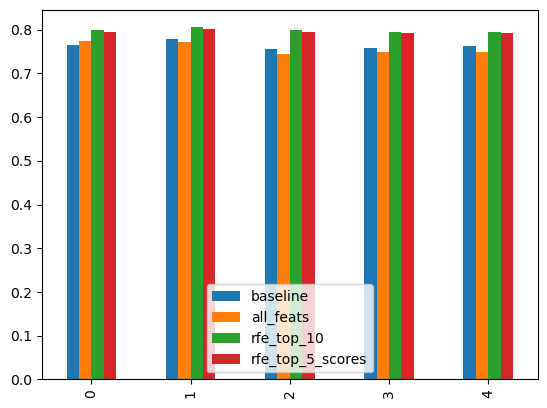

In [40]:
results_df = pd.DataFrame({'baseline':baseline_scores, 
                           'all_feats': all_feat_scores, 
                           'rfe_top_10': rfe_top_10_scores, 
                          'rfe_top_5_scores': rfe_top_5_scores})
results_df.plot(y=["baseline", "all_feats", "rfe_top_10", 'rfe_top_5_scores'], kind="bar")

## Additional modelling- Tree based and boosting models & RandomizedSearchCV

### RandomForestClassifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [47]:
param_vals = {'max_depth': [200, 500, 800], 'n_estimators': [50,100, 200, 300, 400]
              }

In [48]:
model= RandomForestClassifier()
random_rf = RandomizedSearchCV(estimator=model, param_distributions=param_vals,
                              n_iter=10, scoring='roc_auc', cv=5,
                              refit=True, n_jobs=-1)

In [49]:
random_rf.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [200, 500, 800],
                                        'n_estimators': [50, 100, 200, 300,
                                                         400]},
                   scoring='roc_auc')

In [51]:
best_rf = random_rf.best_estimator_
best_rf

RandomForestClassifier(max_depth=800, n_estimators=400)

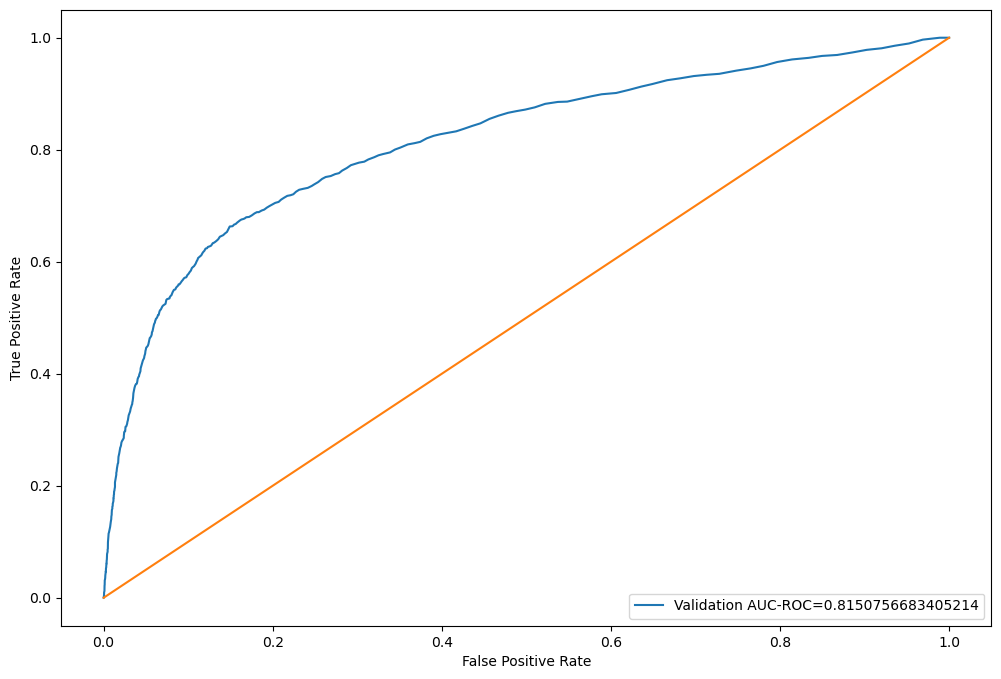

In [53]:
pred = best_rf.predict_proba(xtest)[:,1]
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ytest,pred) 
auc = roc_auc_score(ytest, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [54]:
cv_score(best_rf)


1 of kfold 5
ROC AUC Score: 0.8330060630973178, Recall Score: 0.4325, Precision Score: 0.7121 

2 of kfold 5
ROC AUC Score: 0.8464667557291133, Recall Score: 0.4506, Precision Score: 0.7633 

3 of kfold 5
ROC AUC Score: 0.8444616943176287, Recall Score: 0.4392, Precision Score: 0.7428 

4 of kfold 5
ROC AUC Score: 0.836150884951386, Recall Score: 0.4382, Precision Score: 0.7125 

5 of kfold 5
ROC AUC Score: 0.8324156204362757, Recall Score: 0.4354, Precision Score: 0.7201 


[0.8330060630973178,
 0.8464667557291133,
 0.8444616943176287,
 0.836150884951386,
 0.8324156204362757]